In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np 

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
dog_csv_path = 'archive\dogs.csv'
dogs_df = pd.read_csv('archive\dogs.csv')
dogs_df.head()

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train


In [9]:
import keras
train_path = 'archive/train'
data = tf.keras.utils.image_dataset_from_directory(train_path)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 7946 files belonging to 70 classes.


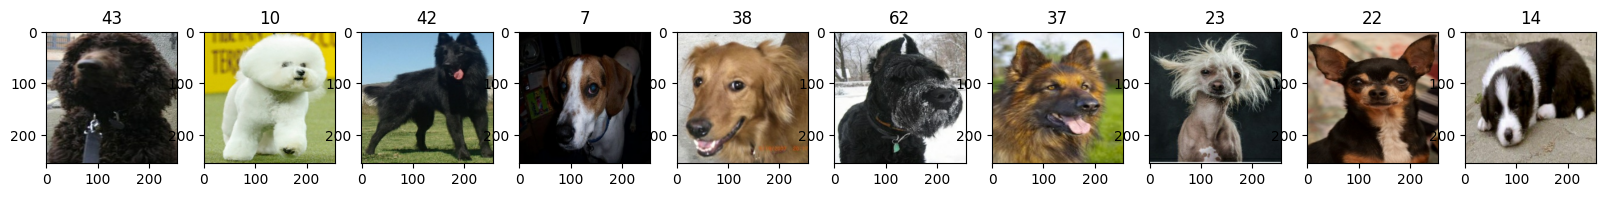

In [11]:
fig, ax= plt.subplots(ncols = 10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
